<a href="https://colab.research.google.com/github/KBVKarthik/Keras-Computer-Vision-Models/blob/main/CutMix_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

In [38]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
]

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [39]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

In [40]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label


In [41]:
train_ds_one = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)
train_ds_two = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
)

train_ds_simple = tf.data.Dataset.from_tensor_slices((x_train, y_train))

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds_simple = (
    train_ds_simple.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [42]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  # rw
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  # rh
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # rx
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  # ry

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]


    lambda_value = sample_beta_distribution(1, alpha, beta)


    lambda_value = lambda_value[0][0]


    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)


    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )

    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )

    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )


    image1 = image1 - img1

    image = image1 + image2


    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)


    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


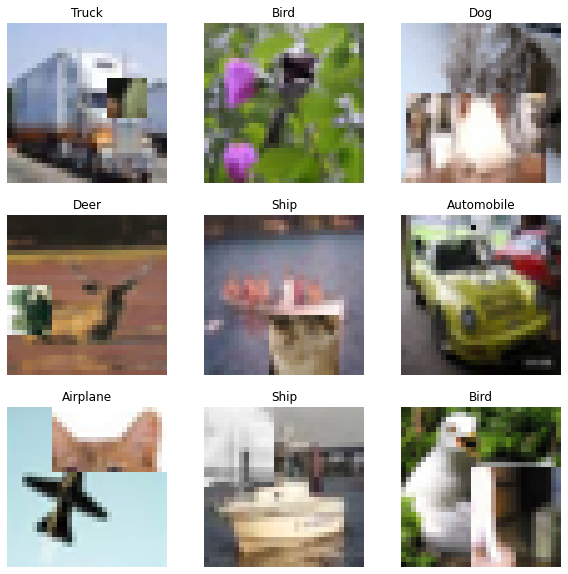

In [43]:
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)


image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [44]:
def resnet_layer(
    inputs,
    num_filters=16,
    kernel_size=3,
    strides=1,
    activation="relu",
    batch_normalization=True,
    conv_first=True,
):
    conv = keras.layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer="he_normal",
        kernel_regularizer=keras.regularizers.l2(1e-4),
    )
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v20(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")

    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)

    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  
                strides = 2  
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:  

                x = resnet_layer(
                    inputs=x,
                    num_filters=num_filters,
                    kernel_size=1,
                    strides=strides,
                    activation=None,
                    batch_normalization=False,
                )
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2


    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(
        num_classes, activation="softmax", kernel_initializer="he_normal"
    )(y)


    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model


def training_model():
    return resnet_v20((32, 32, 3), 20)


initial_model = training_model()
initial_model.save_weights("initial_weights.h5")

In [45]:
model = training_model()
model.load_weights("initial_weights.h5")

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_cmu, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 41s 24ms/step - loss: 1.9125 - accuracy: 0.4115 - val_loss: 1.4686 - val_accuracy: 0.5476
Epoch 2/15
1563/1563 [==============================] - 39s 25ms/step - loss: 1.6568 - accuracy: 0.5368 - val_loss: 1.5529 - val_accuracy: 0.5112
Epoch 3/15
1563/1563 [==============================] - 37s 24ms/step - loss: 1.5506 - accuracy: 0.5840 - val_loss: 1.1153 - val_accuracy: 0.6651
Epoch 4/15
1563/1563 [==============================] - 39s 25ms/step - loss: 1.4898 - accuracy: 0.6152 - val_loss: 1.0737 - val_accuracy: 0.6861
Epoch 5/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.4521 - accuracy: 0.6328 - val_loss: 1.2493 - val_accuracy: 0.6293
Epoch 6/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.4168 - accuracy: 0.6497 - val_loss: 0.9263 - val_accuracy: 0.7379
Epoch 7/15
1563/1563 [==============================] - 38s 24ms/step - loss: 1.3928 - accuracy: 0.6595 - val_loss: 1.0466 -

In [46]:
model = training_model()
model.load_weights("initial_weights.h5")
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_simple, validation_data=test_ds, epochs=15)

test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 29s 17ms/step - loss: 1.4874 - accuracy: 0.5176 - val_loss: 1.3902 - val_accuracy: 0.5502
Epoch 2/15
1563/1563 [==============================] - 26s 17ms/step - loss: 1.0815 - accuracy: 0.6731 - val_loss: 1.3472 - val_accuracy: 0.5985
Epoch 3/15
1563/1563 [==============================] - 26s 17ms/step - loss: 0.9050 - accuracy: 0.7397 - val_loss: 1.1028 - val_accuracy: 0.6742
Epoch 4/15
1563/1563 [==============================] - 27s 17ms/step - loss: 0.7959 - accuracy: 0.7807 - val_loss: 1.0588 - val_accuracy: 0.7038
Epoch 5/15
1563/1563 [==============================] - 26s 17ms/step - loss: 0.7181 - accuracy: 0.8151 - val_loss: 1.3050 - val_accuracy: 0.6667
Epoch 6/15
1563/1563 [==============================] - 27s 17ms/step - loss: 0.6598 - accuracy: 0.8382 - val_loss: 1.3010 - val_accuracy: 0.6650
Epoch 7/15
1563/1563 [==============================] - 27s 17ms/step - loss: 0.6143 - accuracy: 0.8566 - val_loss: 1.4702 -